## Sistem Rekomendasi TMDB Movie

Di era platform streaming dan big‑budget productions, investasi untuk membuat satu film bisa mencapai ratusan juta dolar. Meski begitu, banyak judul blockbuster tetap gagal secara komersial (“box‑office flop”), menimbulkan kerugian finansial besar. Di sisi lain, penonton menghadapi ribuan pilihan judul yang membuat proses memilih film menjadi sulit (paradox of choice). Sistem rekomendasi film membantu:  
1. **Pengguna** menemukan judul yang sesuai minatnya.  
2. **Studio/platform** meminimalkan risiko flop dengan memprediksi tema dan genre yang berpotensi laku.  

**Referensi Terkait**:  
- [The Netflix Recommender System: Algorithms, Business Value, and Innovation](https://ailab-ua.github.io/courses/resources/netflix_recommender_system_tmis_2015.pdf)  
- [A Survey of Movie Recommendation Techniques](https://medium.com/@akshaymouryaart/a-survey-on-movie-recommendation-system-d9610777f8e5)  

### 1.Import Library

Kode pada cell ini mengimpor pustaka-pustaka yang diperlukan untuk analisis data, pemrosesan teks, dan visualisasi. Pustaka tersebut mencakup `pandas` dan `numpy` untuk manipulasi data, `json` untuk pengolahan data JSON, `scikit-learn` untuk ekstraksi fitur teks dan penghitungan kesamaan, serta `matplotlib` untuk visualisasi data. Semua pustaka ini digunakan untuk mendukung proses analisis dan pengembangan sistem rekomendasi.

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

## 2. Data Understanding

### 2.1 Memuat Dataset

Kode berikut digunakan untuk memuat dataset TMDB Movie ke dalam sebuah DataFrame menggunakan pustaka `pandas`. Dataset ini disimpan dalam file CSV bernama `tmdb_5000_movies.csv`. Setelah dataset dimuat, lima baris pertama dari dataset ditampilkan menggunakan fungsi `head()`. Hal ini bertujuan untuk memahami struktur data, termasuk kolom-kolom yang tersedia dan beberapa nilai awalnya.

In [11]:
# Load the dataset
movies = pd.read_csv('./tmdb_5000_movies.csv')

# Tampilkan 5 data teratas
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


### 2.2 Analisis Kualitas Data

Kode berikut digunakan untuk menganalisis kualitas dataset dengan cara:
1. **`movies.info()`**: Menampilkan informasi umum tentang dataset, termasuk jumlah baris, kolom, tipe data, dan jumlah nilai non-null di setiap kolom.
2. **`movies.isnull().sum()`**: Menghitung jumlah nilai yang hilang (missing values) di setiap kolom.
3. **`movies.duplicated().sum()`**: Menghitung jumlah baris duplikat dalam dataset.

#### Insight dari Output
1. **Informasi Dataset**:
    - Dataset memiliki **4803 baris** dan **20 kolom**.
    - Kolom memiliki berbagai tipe data, termasuk `int64`, `float64`, dan `object`.
    - Beberapa kolom memiliki nilai yang hilang, seperti `homepage` (3091 nilai hilang), `overview` (3 nilai hilang), `release_date` (1 nilai hilang), `runtime` (2 nilai hilang), dan `tagline` (844 nilai hilang).
    - Tidak ada baris duplikat dalam dataset.

2. **Kapasitas Memori**:
    - Dataset menggunakan **750.6 KB** memori.

3. **Kualitas Data**:
    - Kolom seperti `homepage` dan `tagline` memiliki banyak nilai yang hilang, sehingga perlu dipertimbangkan apakah kolom ini relevan untuk analisis atau perlu dihapus.
    - Kolom lain seperti `overview`, `release_date`, dan `runtime` memiliki sedikit nilai yang hilang, sehingga dapat diisi (imputasi) atau dihapus barisnya.

In [19]:
# tampilkan informasi dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [20]:
# missing values dan duplicate values
print("Missing values:")
print(movies.isnull().sum())
print("\nDuplicate values:")
print(movies.duplicated().sum())

Missing values:
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

Duplicate values:
0


### 2.3 Exploratory Data Analysis (EDA)

#### Distribusi Genre Film

Kode di atas digunakan untuk menganalisis distribusi genre film dalam dataset. Berikut adalah langkah-langkah yang dilakukan:

1. **Ekstraksi Genre**:
    - Kolom `genres` yang berisi data dalam format JSON diubah menjadi daftar nama genre menggunakan fungsi `json.loads` dan `lambda`.
    - Hasilnya disimpan dalam kolom baru bernama `genres_list`.

2. **Menggabungkan Semua Genre**:
    - Semua genre dari setiap film digabungkan menjadi satu daftar menggunakan list comprehension, menghasilkan variabel `all_genres`.

3. **Menghitung Frekuensi Genre**:
    - Frekuensi kemunculan setiap genre dihitung menggunakan `pd.Series` dan `value_counts()`.
    - Hanya 10 genre teratas yang diambil untuk analisis lebih lanjut.

4. **Visualisasi**:
    - Data frekuensi genre divisualisasikan dalam bentuk diagram batang menggunakan `matplotlib`.
    - Diagram ini menunjukkan 10 genre teratas berdasarkan jumlah kemunculannya dalam dataset.

#### Output Visualisasi

Diagram batang yang dihasilkan menunjukkan distribusi 10 genre teratas dalam dataset. Genre dengan jumlah kemunculan tertinggi adalah **Drama**, diikuti oleh **Comedy**, **Thriller**, dan genre lainnya. Visualisasi ini memberikan gambaran umum tentang genre yang paling sering muncul dalam dataset.

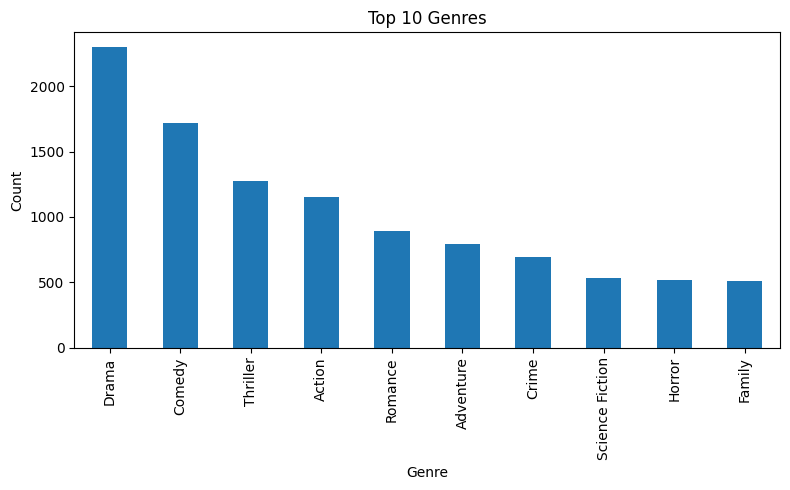

In [21]:
# Exploratory Data Analysis (EDA)
# Tampilkan distribusi Genre
movies['genres_list'] = movies['genres'].apply(json.loads).apply(lambda x: [d['name'] for d in x])
all_genres = [g for sub in movies['genres_list'] for g in sub]
genre_counts = pd.Series(all_genres).value_counts().head(10)

plt.figure(figsize=(8,5))
genre_counts.plot(kind='bar')
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tight_layout()
plt.show()